In [2]:

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Tuple, Optional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report, confusion_matrix,
                             silhouette_score)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)


In [7]:
df = pd.read_csv("./personality_dataset.csv")
data = df.copy() #a copy of data
df.shape
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [8]:
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate.head()

Friends_circle_size    0.026552
Stage_fear             0.025172
Going_outside          0.022759
Post_frequency         0.022414
Time_spent_Alone       0.021724
dtype: float64

In [9]:
X = df.drop('Personality' , axis=1)
y = df['Personality']

# Remove duplicate rows

In [10]:
before = len(data)
data = data.drop_duplicates()
print(f"Duplicates removed: {before - len(data)}")

Duplicates removed: 388


# Remove fixed columns

In [11]:
nunique = data.nunique(dropna=False)
constant_cols = nunique[nunique <= 1].index.tolist()
if constant_cols:
    print("Dropped constant columns:", constant_cols)
    data = data.drop(columns=constant_cols)

# If the 'Personality' tag is also Missing, we delete its rows

In [12]:
missing_y = data["Personality"].isna().sum()
if missing_y:
    print("Rows removed due to missing target:", missing_y)
    data = data[~data["Personality"].isna()].copy()

In [13]:

print("Shape after basic cleaning:", data.shape)
data.head()

Shape after basic cleaning: (2512, 8)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


# Missing rate report by column

In [14]:
na_rate = data.isna().mean().sort_values(ascending=False)
display(na_rate.head(20))

Friends_circle_size          0.029857
Stage_fear                   0.029061
Going_outside                0.025876
Post_frequency               0.025080
Social_event_attendance      0.024283
Time_spent_Alone             0.024283
Drained_after_socializing    0.020303
Personality                  0.000000
dtype: float64

# Threshold for deleting columns due to high Missing

In [15]:
COL_DROP_THRESHOLD = 0.60
cols_to_drop = na_rate[na_rate > COL_DROP_THRESHOLD].index.tolist()
if cols_to_drop:
    print("Dropping columns (too many missing):", cols_to_drop)
    data = data.drop(columns=cols_to_drop)

# Specifying numeric/text columns for pivoting

In [17]:
cat_cols = data.drop(columns=["Personality"]).select_dtypes(include="object").columns.tolist()
num_cols = data.drop(columns=["Personality"]).select_dtypes(exclude="object").columns.tolist()
print("Numeric columns:", num_cols[:10], "... total:", len(num_cols))
print("Categorical columns:", cat_cols[:10], "... total:", len(cat_cols))
for c in num_cols:
    if data[c].isna().any():
        med = data[c].median()
        data[c] = data[c].fillna(med)
for c in cat_cols:
    if data[c].isna().any():
        mode_val = data[c].mode(dropna=True)
        fill_val = mode_val.iloc[0] if len(mode_val) else "missing"
        data[c] = data[c].fillna(fill_val)

Numeric columns: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency'] ... total: 5
Categorical columns: ['Stage_fear', 'Drained_after_socializing'] ... total: 2


In [18]:
print("Remaining missing (should be 0 except rare cases):")
print(data.isna().sum().sum(), "cells")

Remaining missing (should be 0 except rare cases):
0 cells


# Identify and manage Outliers data

In [19]:
def cap_outliers_iqr(df_num: pd.DataFrame, cols, iqr_mult=1.5, report=True):
    dfc = df_num.copy()
    changed = {}
    for col in cols:
        s = dfc[col].astype(float)
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr) or iqr == 0:
            continue
        lo, hi = q1 - iqr_mult * iqr, q3 + iqr_mult * iqr
        before = ((s < lo) | (s > hi)).sum()
        dfc[col] = s.clip(lo, hi)
        after = ((dfc[col] < lo) | (dfc[col] > hi)).sum()
        if report and before > 0:
            changed[col] = {"capped_count": int(before), "low": float(lo), "high": float(hi)}
    if report and changed:
        print("IQR capping report (counts & bounds):")
        for k, v in changed.items():
            print(f" - {k}: capped={v['capped_count']}  bounds=({v['low']:.3f}, {v['high']:.3f})")
    return dfc


data[num_cols] = cap_outliers_iqr(data[num_cols], num_cols, iqr_mult=1.5)


from scipy.stats import zscore
z = data[num_cols].apply(lambda s: np.abs(zscore(s, nan_policy='omit')))
still_outliers = (z > 4).sum().sum()
print("Remaining extreme points (|z|>4) ~ rough check:", int(still_outliers))


X_clean = data.drop(columns=["Personality"])
y_clean = data["Personality"]

print("Final shapes -> X:", X_clean.shape, " y:", y_clean.shape)


Remaining extreme points (|z|>4) ~ rough check: 0
Final shapes -> X: (2512, 7)  y: (2512,)


# Split data

In [20]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,              
    random_state=42,
    stratify=y_clean            
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,            
    random_state=42,
    stratify=y_trainval
)

In [21]:
print("Train shape     :", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape      :", X_test.shape, y_test.shape)

Train shape     : (1506, 7) (1506,)
Validation shape: (503, 7) (503,)
Test shape      : (503, 7) (503,)


# Preprocessing Pipeline

In [22]:
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(exclude="object").columns.tolist()

num_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler())                    
])

cat_trans = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     
])

preprocess = ColumnTransformer([
    ("num", num_trans, num_cols),
    ("cat", cat_trans, cat_cols)
])


# Label Encoding

In [26]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
avg_type = "binary" if len(le.classes_) == 2 else "macro"

# SVM training and selecting the best parameter

In [32]:

svm_candidates = []
for C in [0.1, 1, 10]:
    for gamma in ["scale", "auto"]:
        clf = Pipeline([
            ("prep", preprocess),
            ("model", SVC(kernel="rbf", C=C, gamma=gamma, probability=True, class_weight="balanced", random_state=42))
        ])
        clf.fit(X_train, y_train_enc)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val_enc, y_val_pred, average=avg_type)
        svm_candidates.append(((C, gamma), f1, clf))

best_C, best_gamma = max(svm_candidates, key=lambda x: x[1])[0]

# decision tree training and selecting the best parameter

In [33]:
dt_candidates = []
for max_depth in [None, 5, 10, 20]:
    for min_split in [2, 10]:
        clf = Pipeline([
            ("prep", preprocess),
            ("model", DecisionTreeClassifier(
                random_state=42, class_weight="balanced",
                max_depth=max_depth, min_samples_split=min_split
            ))
        ])
        clf.fit(X_train, y_train_enc)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val_enc, y_val_pred, average=avg_type)
        dt_candidates.append(((max_depth, min_split), f1, clf))

best_depth, best_split = max(dt_candidates, key=lambda x: x[1])[0]

# Final training with the best parameters and evaluation on Test

In [38]:
svm_final = Pipeline([
    ("prep", preprocess),
    ("model", SVC(kernel="rbf", C=best_C, gamma=best_gamma, probability=True, class_weight="balanced", random_state=42))
])
svm_final.fit(pd.concat([X_train, X_val]), le.transform(pd.concat([y_train, y_val])))
y_test_pred_svm = svm_final.predict(X_test)

print(classification_report(y_test_enc, y_test_pred_svm))
print(confusion_matrix(y_test_enc, y_test_pred_svm))

dt_final = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(random_state=42, class_weight="balanced", max_depth=best_depth, min_samples_split=best_split))
])
dt_final.fit(pd.concat([X_train, X_val]), le.transform(pd.concat([y_train, y_val])))
y_test_pred_dt = dt_final.predict(X_test)

print("\nDecision Tree Test Report:")
print(classification_report(y_test_enc, y_test_pred_dt, zero_division=0))
print("Confusion Matrix (DT):\n", confusion_matrix(y_test_enc, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       284
           1       0.88      0.93      0.90       219

    accuracy                           0.91       503
   macro avg       0.91      0.92      0.91       503
weighted avg       0.92      0.91      0.91       503

[[256  28]
 [ 15 204]]

Decision Tree Test Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       284
           1       0.88      0.93      0.90       219

    accuracy                           0.91       503
   macro avg       0.91      0.92      0.91       503
weighted avg       0.92      0.91      0.91       503

Confusion Matrix (DT):
 [[256  28]
 [ 15 204]]


# Draw ROC Curve

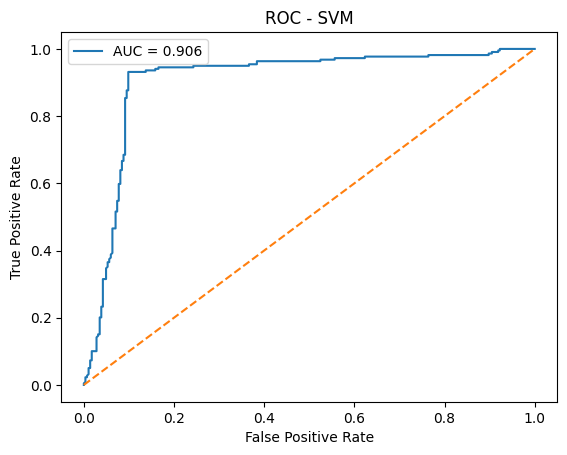

In [36]:
y_proba_svm = svm_final.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test_enc, y_proba_svm[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - SVM")
plt.legend()
plt.show()

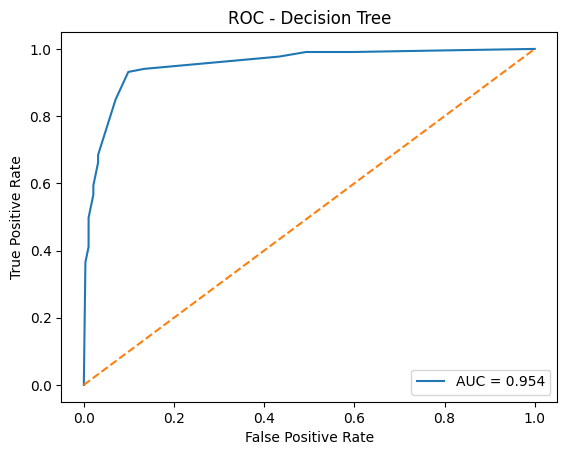

In [39]:
y_proba_dt = dt_final.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test_enc,  y_proba_dt[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Decision Tree")
plt.legend()
plt.show()

# Data preparation

In [41]:
X_full = df.drop(columns=['Personality'])

cat_cols_full = X_full.select_dtypes(include="object").columns.tolist()
num_cols_full = X_full.select_dtypes(exclude="object").columns.tolist()

prep_cluster = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols_full),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols_full),
], remainder="drop")

Z = prep_cluster.fit_transform(X_full)

# Elbow Method

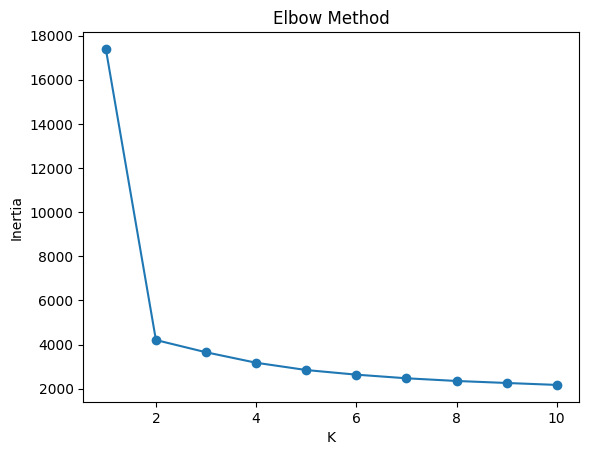

In [42]:
inertias = []
Ks = list(range(1, 11))
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(Z)
    inertias.append(km.inertia_)

plt.plot(Ks, inertias, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Silhouette Score (K>=2)


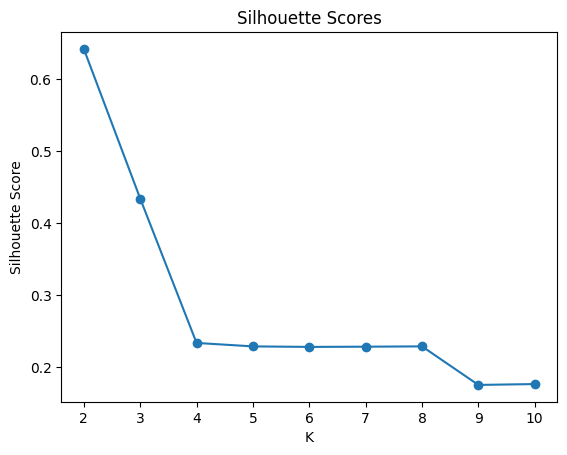

In [43]:
sils = []
Ks_sil = list(range(2, 11))
for k in Ks_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Z)
    sils.append(silhouette_score(Z, labels))

plt.plot(Ks_sil, sils, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")
plt.show()

# Choosing the best K based on the highest Silhouette

In [44]:
best_k = Ks_sil[int(np.argmax(sils))]
print("Selected K:", best_k)

Selected K: 2


# K-Means

In [45]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(Z)

df_clusters = df.copy()
df_clusters['Cluster'] = cluster_labels
df_clusters.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Cluster
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert,0
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert,1
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert,1
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert,0
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert,0


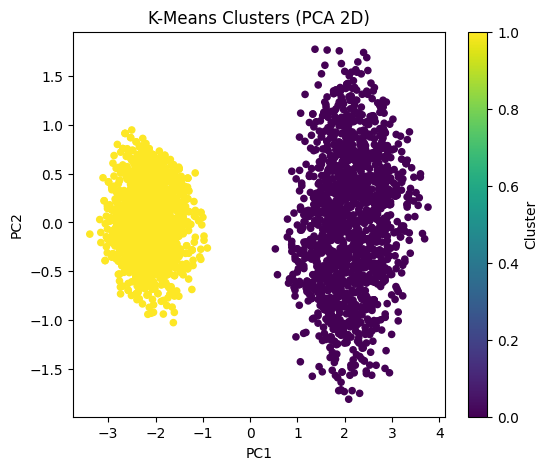

In [46]:
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

plt.figure(figsize=(6, 5))
plt.scatter(Z2[:, 0], Z2[:, 1], c=cluster_labels, cmap='viridis', s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters (PCA 2D)")
plt.colorbar(label="Cluster")
plt.show()

#  analysis of each cluster

In [47]:
dfc = df.drop(columns=['Personality']).copy()
dfc["Cluster"] = cluster_labels
rows = []
for k in sorted(dfc["Cluster"].unique()):
    sub = dfc[dfc["Cluster"] == k]
    row = {"Cluster": k, "Size": len(sub)}
    for col in num_cols_full:
        row[f"mean_{col}"] = sub[col].mean()
    for col in cat_cols_full:
        mode_val = sub[col].mode(dropna=True)
        row[f"mode_{col}"] = mode_val.iloc[0] if not mode_val.empty else None
    rows.append(row)
cluster_summary = pd.DataFrame(rows)
cluster_summary

,Cluster,Size,mean_Time_spent_Alone,mean_Social_event_attendance,mean_Going_outside,mean_Friends_circle_size,mean_Post_frequency,mode_Stage_fear,mode_Drained_after_socializing
0,0,1459,1.529123,6.440559,4.970526,9.830867,6.049123,No,No
1,1,1441,7.509915,1.447443,1.007097,2.668803,1.053901,Yes,Yes
